# CSCA 5622 Supervised Learning Final Project

## Project Overview and Problem Statement

This project focuses on predicting customer churn in the telecommunications industry. Churn refers to customers who leave a service provider, and predicting churn is crucial for improving customer retention and business profitability.

The problem is formulated as a supervised learning task, where the goal is to predict a binary outcome, whether a customer will churn (Yes) or not (No).

Since the target variable is categorical with two possible outcomes, this is a binary classification problem. Various classification algorithms will be explored and compared to build a robust predictive model.
Through this project, I aim to understand which features most strongly influence customer churn, evaluate model performance using appropriate metrics (e.g., ROC-AUC, F1-score), and identify the best-performing supervised learning approach for this classification task.

## Data Source

The dataset used in this project is the Telco Customer Churn dataset, which contains customer information from a telecommunications company, including demographic details, account data, services subscribed to, and whether the customer has churned. The target variable is Churn, indicating if the customer left (Yes) or stayed (No).

The dataset is publicly available on Kaggle: [Telco Customer Churn – Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

It includes 7043 samples and 20 features, with a mix of numerical, binary, and categorical variables.

There is also a more extensive version of this dataset published by IBM, which includes more features and additional records:
[IBM Telco Customer Churn (extended version)](https://community.ibm.com/community/user/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)

However, for the scope of this project, we use the Kaggle version due to its simpler structure, which is more manageable for demonstrating supervised learning techniques within the project constraints.

### Dataset Explanation

The dataset consists of 7043 rows (customers) and 21 columns (20 features + 1 target variable). It is in tabular format, with each row representing a customer and each column representing a demographic, service-related, or account-related attribute.

Among the features:

- 13 are categorical (e.g., gender, InternetService, Contract)
- 3 are numerical (tenure, MonthlyCharges, TotalCharges)
- 5 are binary (SeniorCitizen, Partner, Dependents, etc.)

The dataset is self-contained (not multi-table) and does not require external data merging. It is relatively small in size (under 1 MB), making it manageable for exploratory data analysis and model experimentation.

Here's the full list of columns in the dataset

* ``customerID``: Unique ID for each customer
* ``gender``: Gender of the customer (`Male` or `Female`)
* ``SeniorCitizen``: Indicates if the customer is a senior (`1` = Yes, `0` = No)
* ``Partner``: Whether the customer has a partner (`Yes` or `No`)
* ``Dependents``: Whether the customer has dependents (`Yes` or `No`)
* ``tenure``: Number of months the customer has been with the company
* ``PhoneService``: Whether the customer has phone service (`Yes` or `No`)
* ``MultipleLines``: Has multiple phone lines (`Yes`, `No`, or `No phone service`)
* ``InternetService``: Type of internet service (`DSL`, `Fiber optic`, or `No`)
* ``OnlineSecurity``: Whether online security is included (`Yes`, `No`, or `No internet service`)
* ``OnlineBackup``: Whether online backup is included (`Yes`, `No`, or `No internet service`)
* ``DeviceProtection``: Whether device protection is included (`Yes`, `No`, or `No internet service`)
* ``TechSupport``: Whether tech support is included (`Yes`, `No`, or `No internet service`)
* ``StreamingTV``: Access to streaming TV (`Yes`, `No`, or `No internet service`)
* ``StreamingMovies``: Access to streaming movies (`Yes`, `No`, or `No internet service`)
* ``Contract``: Type of contract (`Month-to-month`, `One year`, `Two year`)
* ``PaperlessBilling``: Whether billing is paperless (`Yes` or `No`)
* ``PaymentMethod``: Method of payment (`Electronic check`, `Mailed check`, etc.)
* ``MonthlyCharges``: Monthly amount charged to the customer
* ``TotalCharges``: Total amount charged over the tenure
* ``Churn``: Target variable. Whether the customer churned (`Yes` or `No`)


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
import seaborn as sns

In [45]:
# Constants for the EDA and modeling process
TARGET_COLUMN = "Churn"
RANDOM_STATE = 42
K_FOLDS = 5
RESULT_PATH = "./results/"
RESULT_FINE_NAME = "model_comparison_results."
RESULT_FINE_EXT = "csv"
DATASET_PATH = "./data/Telco-Customer-Churn.csv"

## Exploratory Data Analysis (EDA)

### Basic Data Exploration and Preprocessing

In [46]:
df = pd.read_csv(DATASET_PATH, delimiter=',')

In [47]:
print(f'shape: {df.shape}')
print(f'columns: {df.columns.tolist()}')

shape: (7043, 21)
columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [48]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

SeniorCitizen is binary coloumn and it already `int64` type, however, we need to covert columns like gender, Partner, Dependents, etc to `category` type.

In general, we have three categories of columns:
1. Numerical columns
2. Categorical columns
3. Binary columns

However, I also consider separating features based on their domain, such as service, demographic, and payment features. This will help in understanding the data better later on.

One important thing to note is that the `TotalCharges` column is a numerical column, but it has a type of `object` due to some non-numeric values. We need to convert it to a numeric type and handle any errors that arise from non-numeric values.

Before we proceed with the conversion, let's check the unique values in each column to understand the data better.

In [49]:
# unique values in each column
for col in df.columns:
    print(f'{col}: {df[col].nunique()} unique values : {df[col].unique()} unique values')

customerID: 7043 unique values : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] unique values
gender: 2 unique values : ['Female' 'Male'] unique values
SeniorCitizen: 2 unique values : [0 1] unique values
Partner: 2 unique values : ['Yes' 'No'] unique values
Dependents: 2 unique values : ['No' 'Yes'] unique values
tenure: 73 unique values : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39] unique values
PhoneService: 2 unique values : ['No' 'Yes'] unique values
MultipleLines: 3 unique values : ['No phone service' 'No' 'Yes'] unique values
InternetService: 3 unique values : ['DSL' 'Fiber optic' 'No'] unique values
OnlineSecurity: 3 unique values : ['No' 'Yes' 'No internet service'] unique values
OnlineBackup: 3 unique values : ['Yes' 'No' 'No internet service'] unique values
Dev

We can see that the `gender`, `Partner`, `Dependents`, `PhoneService`, and `PaperlessBilling` columns have binary values, while the `InternetService`, `MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, and `StreamingMovies` columns are categorical with multiple unique values. The `Contract` and `PaymentMethod` columns also have categorical values.

In [50]:
demographic_features = ["gender", "SeniorCitizen", "Partner", "Dependents"]
service_features = ["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity",
                    "OnlineBackup", "DeviceProtection", "StreamingTV", "StreamingMovies", "TechSupport"]
payment_features = ["Contract", "PaperlessBilling", "PaymentMethod"]

binary_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']
categorical_features = list(set(service_features + payment_features) - set(binary_features))
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [51]:
# handling TotalCharges column
print(f'TotalCharges type before conversion: {df["TotalCharges"].dtype}, total null values: {df["TotalCharges"].isna().sum()}')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

TotalCharges type before conversion: object, total null values: 0


While converting the `TotalCharges` column to numeric, we use `errors='coerce'` to convert any non-numeric values to NaN. This is important because it allows us to handle any invalid entries without causing the entire conversion to fail. After this conversion, we can decide how to handle these NaN values, either by dropping them or filling them with a specific value.
Let's check how many NaN values we have in the `TotalCharges` column and then drop them if necessary.

In [52]:
print(f'TotalCharges type after conversion: {df["TotalCharges"].dtype}, total null values: {df["TotalCharges"].isna().sum()}')

TotalCharges type after conversion: float64, total null values: 11


Now the data type of `TotalCharges` is `float64`, but we have 11 rows with NaN values after the conversion. Let's check these rows in the original dataframe.

In [53]:
temp_df = pd.read_csv(DATASET_PATH, delimiter=',')
temp_df.loc[df[df['TotalCharges'].isnull()].index, 'TotalCharges']

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object

It is clear that these rows have no values in the `TotalCharges` column, which is why they were converted to NaN. Since these rows do not provide any useful information for our analysis and the total number of rows is small (11), we can safely drop them from the dataset.

In [54]:
df = df.dropna(subset=['TotalCharges'])
print(f'Total null values: {df["TotalCharges"].isna().sum()}')

Total null values: 0


As we saw in the previous steps, `customerID` is a unique identifier for each customer and does not provide any useful information for our analysis. Therefore, we can drop this column from the dataset.

In [55]:
# drop customerID column
df = df.drop(columns=['customerID'])

In [56]:
# check null and duplicated values in the dataset
print(f'Total null values in the dataset: {df.isna().sum().sum()}')
print(f'Total duplicated rows in the dataset: {df.duplicated().sum()}')

Total null values in the dataset: 0
Total duplicated rows in the dataset: 22


We have 22 duplicated rows in the dataset, however, considering these are belong to different customers, we can keep them as they are. We also have no null values in the dataset, which is great.

### Target Variable Distribution

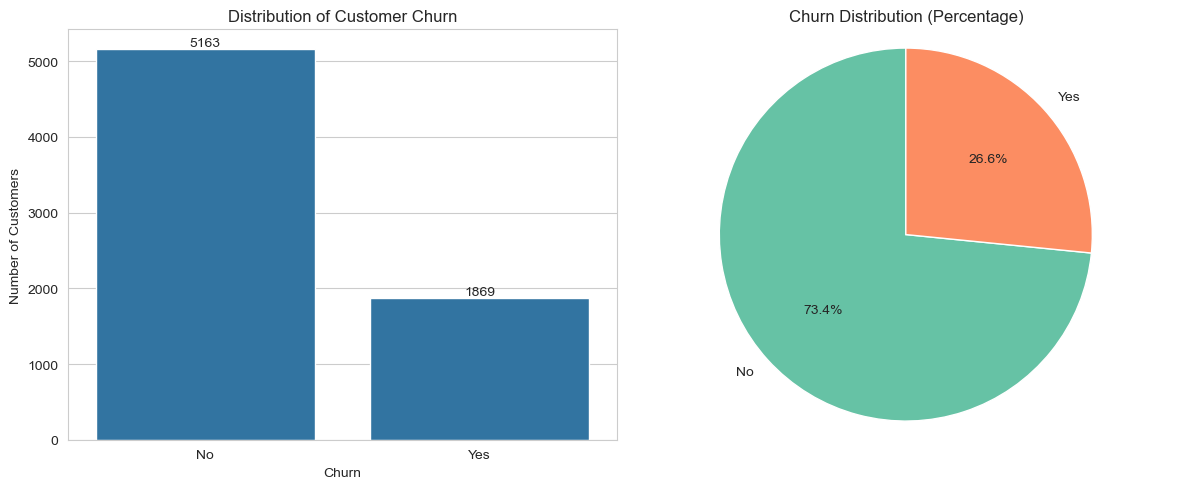

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Countplot
sns.countplot(x="Churn", data=df, ax=axes[0])
axes[0].set_title("Distribution of Customer Churn")
axes[0].set_xlabel("Churn")
axes[0].set_ylabel("Number of Customers")
axes[0].bar_label(axes[0].containers[0])

# Right: Pie Chart
churn_counts = df['Churn'].value_counts()
churn_percent = churn_counts / churn_counts.sum() * 100
axes[1].pie(churn_percent, labels=churn_percent.index, autopct='%1.1f%%',
            startangle=90, colors=['#66c2a5', '#fc8d62'])
axes[1].set_title("Churn Distribution (Percentage)")
axes[1].axis('equal')

plt.tight_layout()
plt.show()


Looking at the distribution of the target variable `Churn`, we can see that the dataset is imbalanced, with a higher number of customers who did not churn compared to those who did. This is a common scenario in churn prediction tasks and will require special attention during model training to ensure that the model does not become biased towards the majority class.

### Numerical Features Analysis

Let's start with the numerical feature analysis. We will check the distribution of each numerical feature and their correlation with the target variable `Churn`. Let's start with a boxplot to visualize the distribution of numerical features.

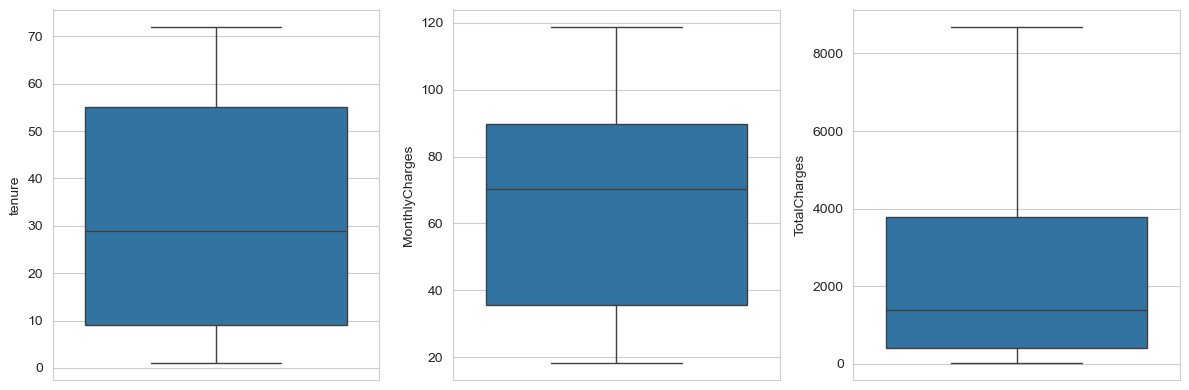

In [58]:
plt.figure(figsize=(12, 4))

for i in range(0, len(numeric_features)):
    plt.subplot(1, len(numeric_features), i + 1)
    sns.boxplot(data=df, y=numeric_features[i])
    plt.tight_layout()

**Analysis of Numerical Features**

The boxplots for `tenure`, `MonthlyCharges`, and `TotalCharges` provide insight into the distribution and spread of these numerical variables. The `tenure` feature shows a relatively wide distribution, with a median around 29 months and no visible outliers, indicating a stable range of customer contract lengths. Similarly, `MonthlyCharges` is moderately right-skewed, with most customers paying between 35 and 90 per month. There are no extreme values beyond the whiskers, suggesting that premium-tier customers fall within a reasonable range.

The `TotalCharges` feature exhibits a pronounced right skew, which is expected given its dependency on both tenure and monthly charges. Although some customers have paid significantly more over time, these values are within the expected bounds and are not treated as outliers. Overall, the numerical features appear well-behaved and do not require special treatment for outliers at this stage of the analysis.


Now, let's analyze the correlation of these numerical features with the target variable `Churn`. We will use a boxplot to visualize the distribution of each numerical feature based on the `Churn` status.

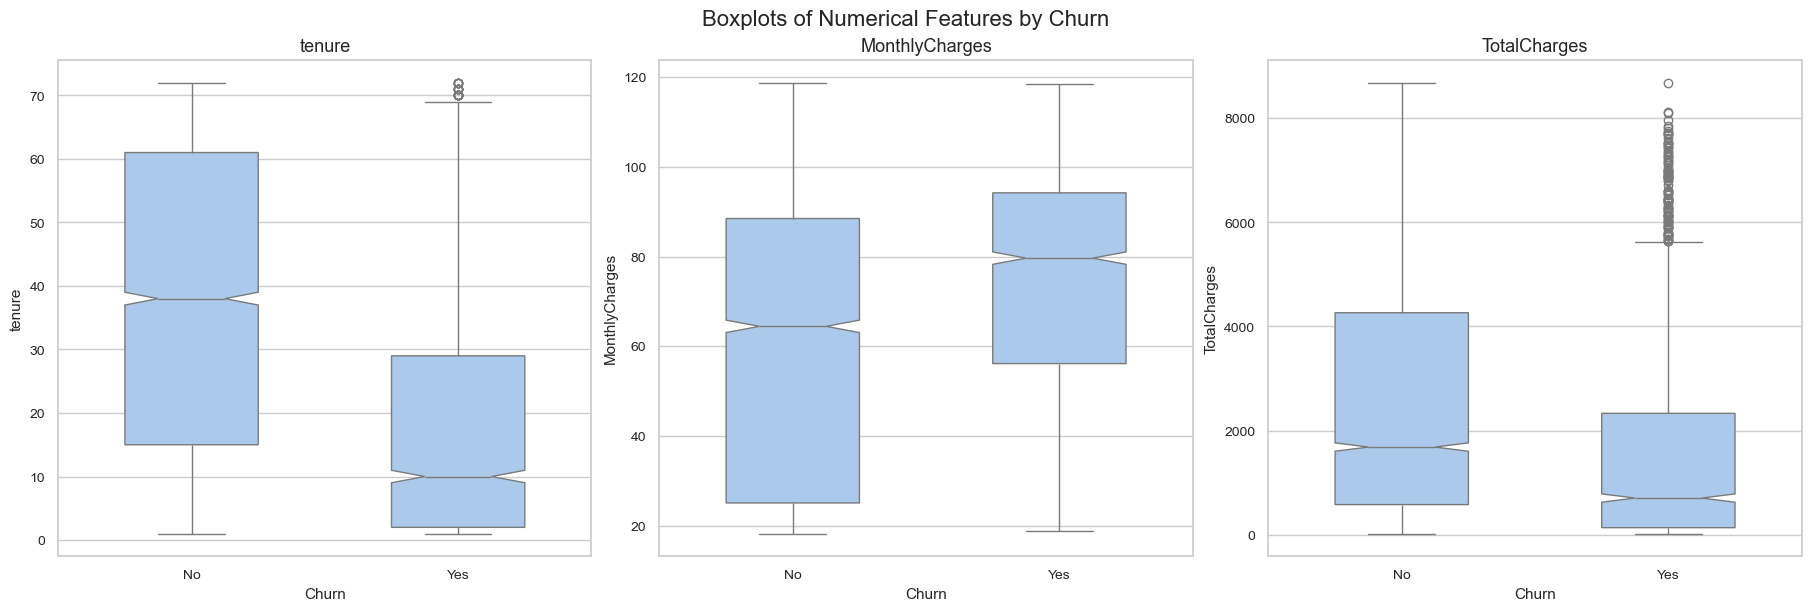

In [70]:
# Set theme


# Create subplots
fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6), constrained_layout=True)

# Loop over numeric features
for i, col in enumerate(numeric_features):
    sns.boxplot(data=df, y=col, x='Churn', ax=axes[i], width=0.5, notch=True)
    axes[i].set_title(f"{col}", fontsize=13)
    axes[i].set_xlabel("Churn", fontsize=11)
    axes[i].set_ylabel(col, fontsize=11)
    axes[i].tick_params(labelsize=10)

# Add main title
fig.suptitle("Boxplots of Numerical Features by Churn", fontsize=16)

plt.show()

The boxplots clearly show different patterns in the numerical features based on churn status. Customers who did not churn have a much higher median `tenure` compared to those who churned, meaning loyal customers tend to stay longer. In contrast, customers who churned often have very short tenure, suggesting that many leave early in their contract period.

For `MonthlyCharges`, customers who churn generally pay more on average than those who stay. This could suggest that higher monthly costs may lead to dissatisfaction or affordability issues. The `TotalCharges` feature also shows a strong difference. Since it is the product of tenure and monthly charges, it makes sense that customers who churn have much lower total charges. This supports the idea that they often leave early. Overall, these numerical features provide useful signals for predicting churn.


To better understand the numerical features, Let's also look at the histogram with KDE (Kernel Density Estimate) for each numerical feature. This will help us visualize the distribution of values and identify any skewness or unusual patterns.

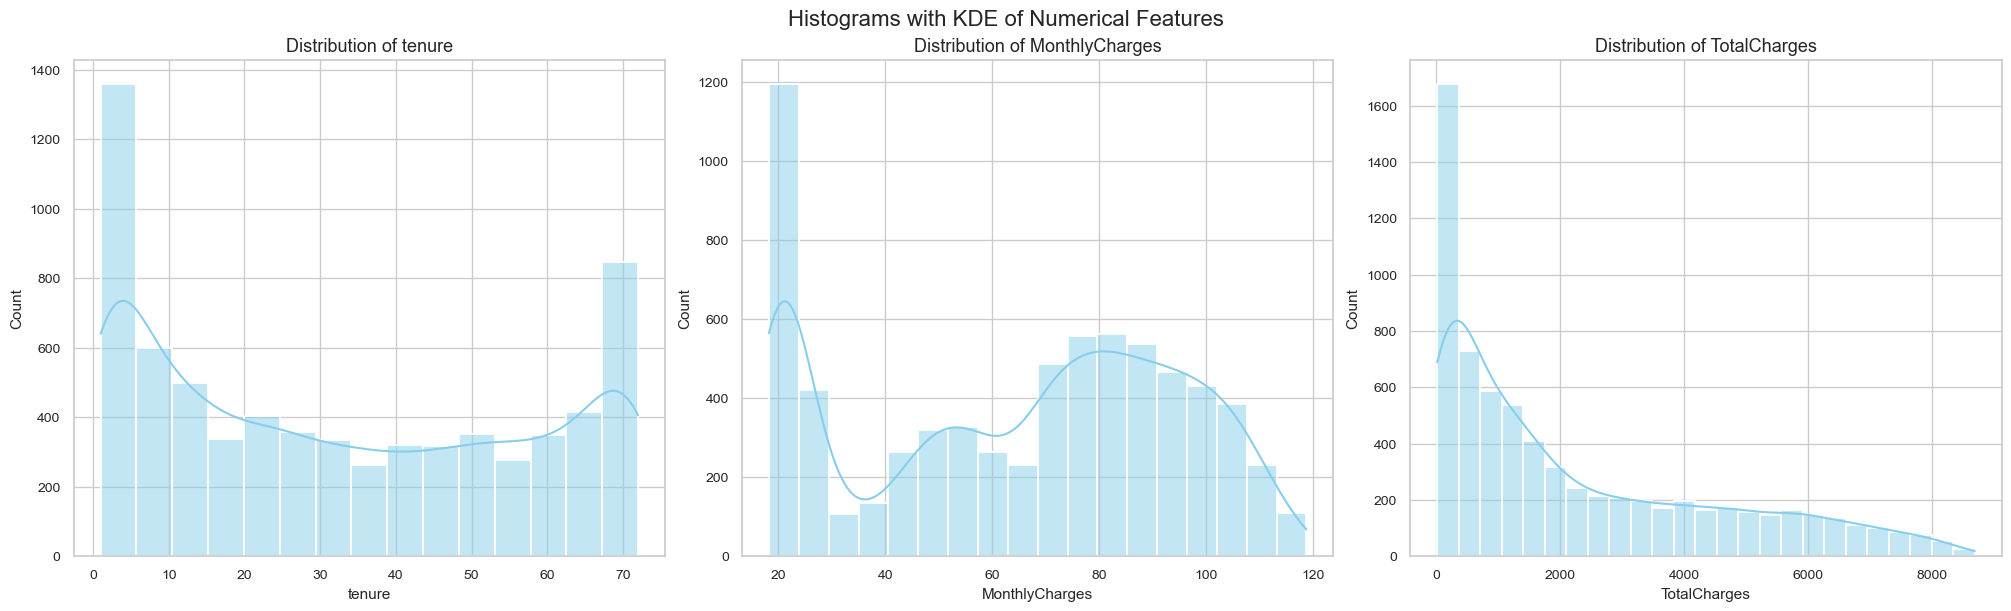

In [72]:
fig, axes = plt.subplots(1, len(numeric_features), figsize=(20, 6), constrained_layout=True)

for i, col in enumerate(numeric_features):
    sns.histplot(df[col], kde=True, ax=axes[i], color="skyblue", edgecolor="white", linewidth=1.3)
    axes[i].set_title(f"Distribution of {col}", fontsize=13)
    axes[i].set_xlabel(col, fontsize=11)
    axes[i].set_ylabel("Count", fontsize=11)
    axes[i].tick_params(labelsize=10)

fig.suptitle("Histograms with KDE of Numerical Features", fontsize=16)
plt.show()

The histograms with KDE curves provide a deeper view of how the numerical features are distributed. The `tenure` variable shows a bimodal pattern, with many customers at the beginning (around 0–10 months) and another peak around 70 months. This suggests that some customers leave very early, while others tend to stay for many years.

The `MonthlyCharges` feature appears roughly right-skewed, with a concentration of customers around 70–90. However, there is also a significant number of customers paying less than 30. The `TotalCharges` variable is strongly right-skewed, which makes sense since it accumulates over time based on both tenure and monthly charges. Many customers have relatively low total charges, likely due to short tenure. These distributions confirm that feature scaling or transformations might be useful before modeling.


Next step, we use `sns.pairplot` to visualize the relationships between numerical features and the target variable `Churn`. This will help us see how these features interact with each other and with churn.

['tenure', 'MonthlyCharges', 'TotalCharges']


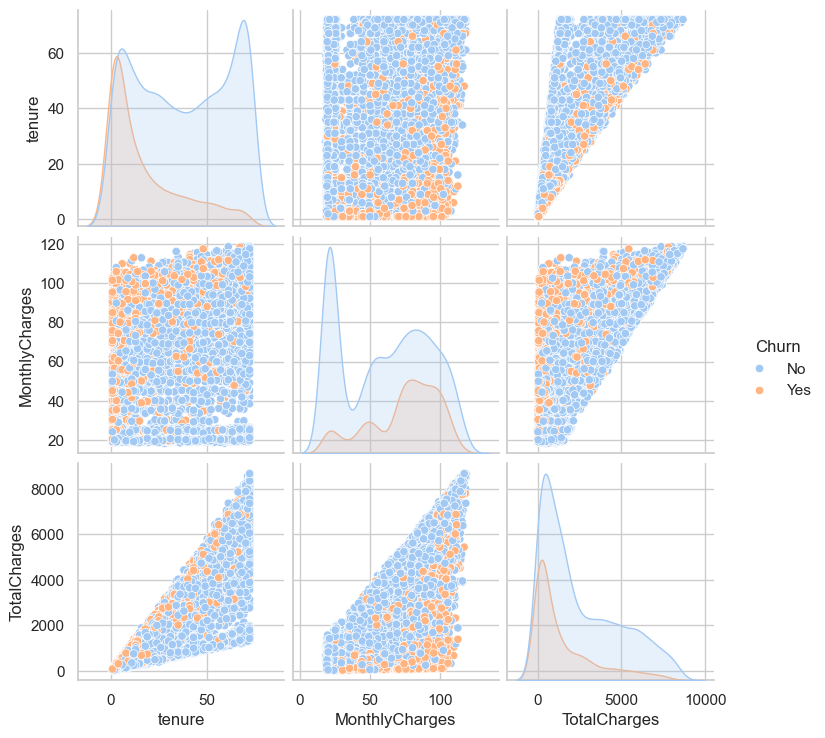

In [77]:
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], hue='Churn')

The pairplot shows the relationships between `tenure`, `MonthlyCharges`, and `TotalCharges`, colored by churn status. We can observe that customers who churned (orange) tend to have lower `tenure` and lower `TotalCharges`, but often have higher `MonthlyCharges`. This supports earlier findings that customers who leave usually do so early and may be paying more per month.

There is also a strong positive linear relationship between `tenure` and `TotalCharges`, which is expected since longer-tenure customers accumulate higher total charges. The density plots along the diagonal show clear separation between churned and non-churned customers, especially in `tenure` and `TotalCharges`. Overall, this plot confirms that these numerical features are useful for distinguishing between churned and retained customers.


Now, let's analyze the correlation matrix for the numerical features, including the target variable `Churn`. This will help us quantify the relationships between these features and identify any strong correlations.

<Axes: >

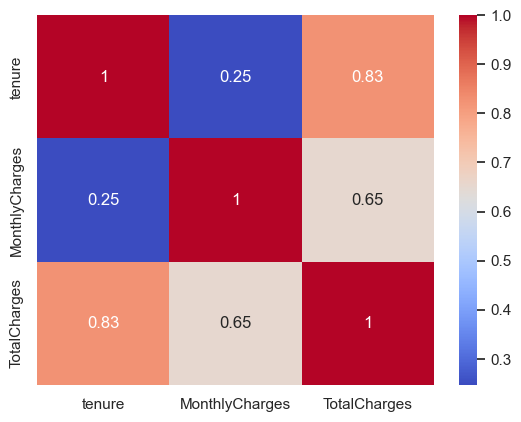

In [81]:
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="coolwarm")

This correlation matrix focuses only on continuous numerical features: `tenure`, `MonthlyCharges`, and `TotalCharges`. The strongest correlation is between `tenure` and `TotalCharges` (0.83), which is expected since the total charges accumulate over time. There is also a moderate positive correlation between `MonthlyCharges` and `TotalCharges` (0.65), showing that customers with higher monthly fees tend to have higher total charges.

The correlation between `tenure` and `MonthlyCharges` is relatively weak (0.25), suggesting that the monthly rate does not strongly depend on how long a customer stays. Overall, this heatmap confirms that `TotalCharges` is influenced by both other features, and that `tenure` and `MonthlyCharges` each contribute useful, but different, information to churn prediction.


#### Summary of Numerical Feature Significance

Based on the exploratory analysis, including boxplots, distribution plots, pairplots, and correlation matrix, we can draw conclusions about the significance of the numerical features in relation to the target variable `Churn`.

The feature `tenure` appears to be the most significant indicator of churn. Customers who churn tend to have much shorter tenure, suggesting they leave early in their customer lifecycle. This is clearly visible in both the boxplots and pairplots, where churned customers are concentrated at low tenure values.

`MonthlyCharges` also shows a moderate association with churn. Customers who churn are more likely to be paying higher monthly fees, which might indicate dissatisfaction or affordability issues. Although the relationship is weaker than with tenure, it still adds meaningful information.

On the other hand, `TotalCharges` is highly correlated with `tenure` (correlation coefficient ≈ 0.83) and is largely derived from it. While it does reflect overall customer spending, it may not add much independent value for churn prediction and could introduce multicollinearity if used alongside `tenure`.

In conclusion, `tenure` and `MonthlyCharges` can be considered significant numerical features for predicting churn, while `TotalCharges` should be used cautiously due to its strong dependency on `tenure`.


### Categorical Features Analysis


For categorical features, we first plot the distribution of each feature based on their values (categories) and then analyze their correlation with the target variable `Churn`. We will use count plots for categorical features and a bar plot for the correlation analysis. Let's start with the count plots for each categorical feature.

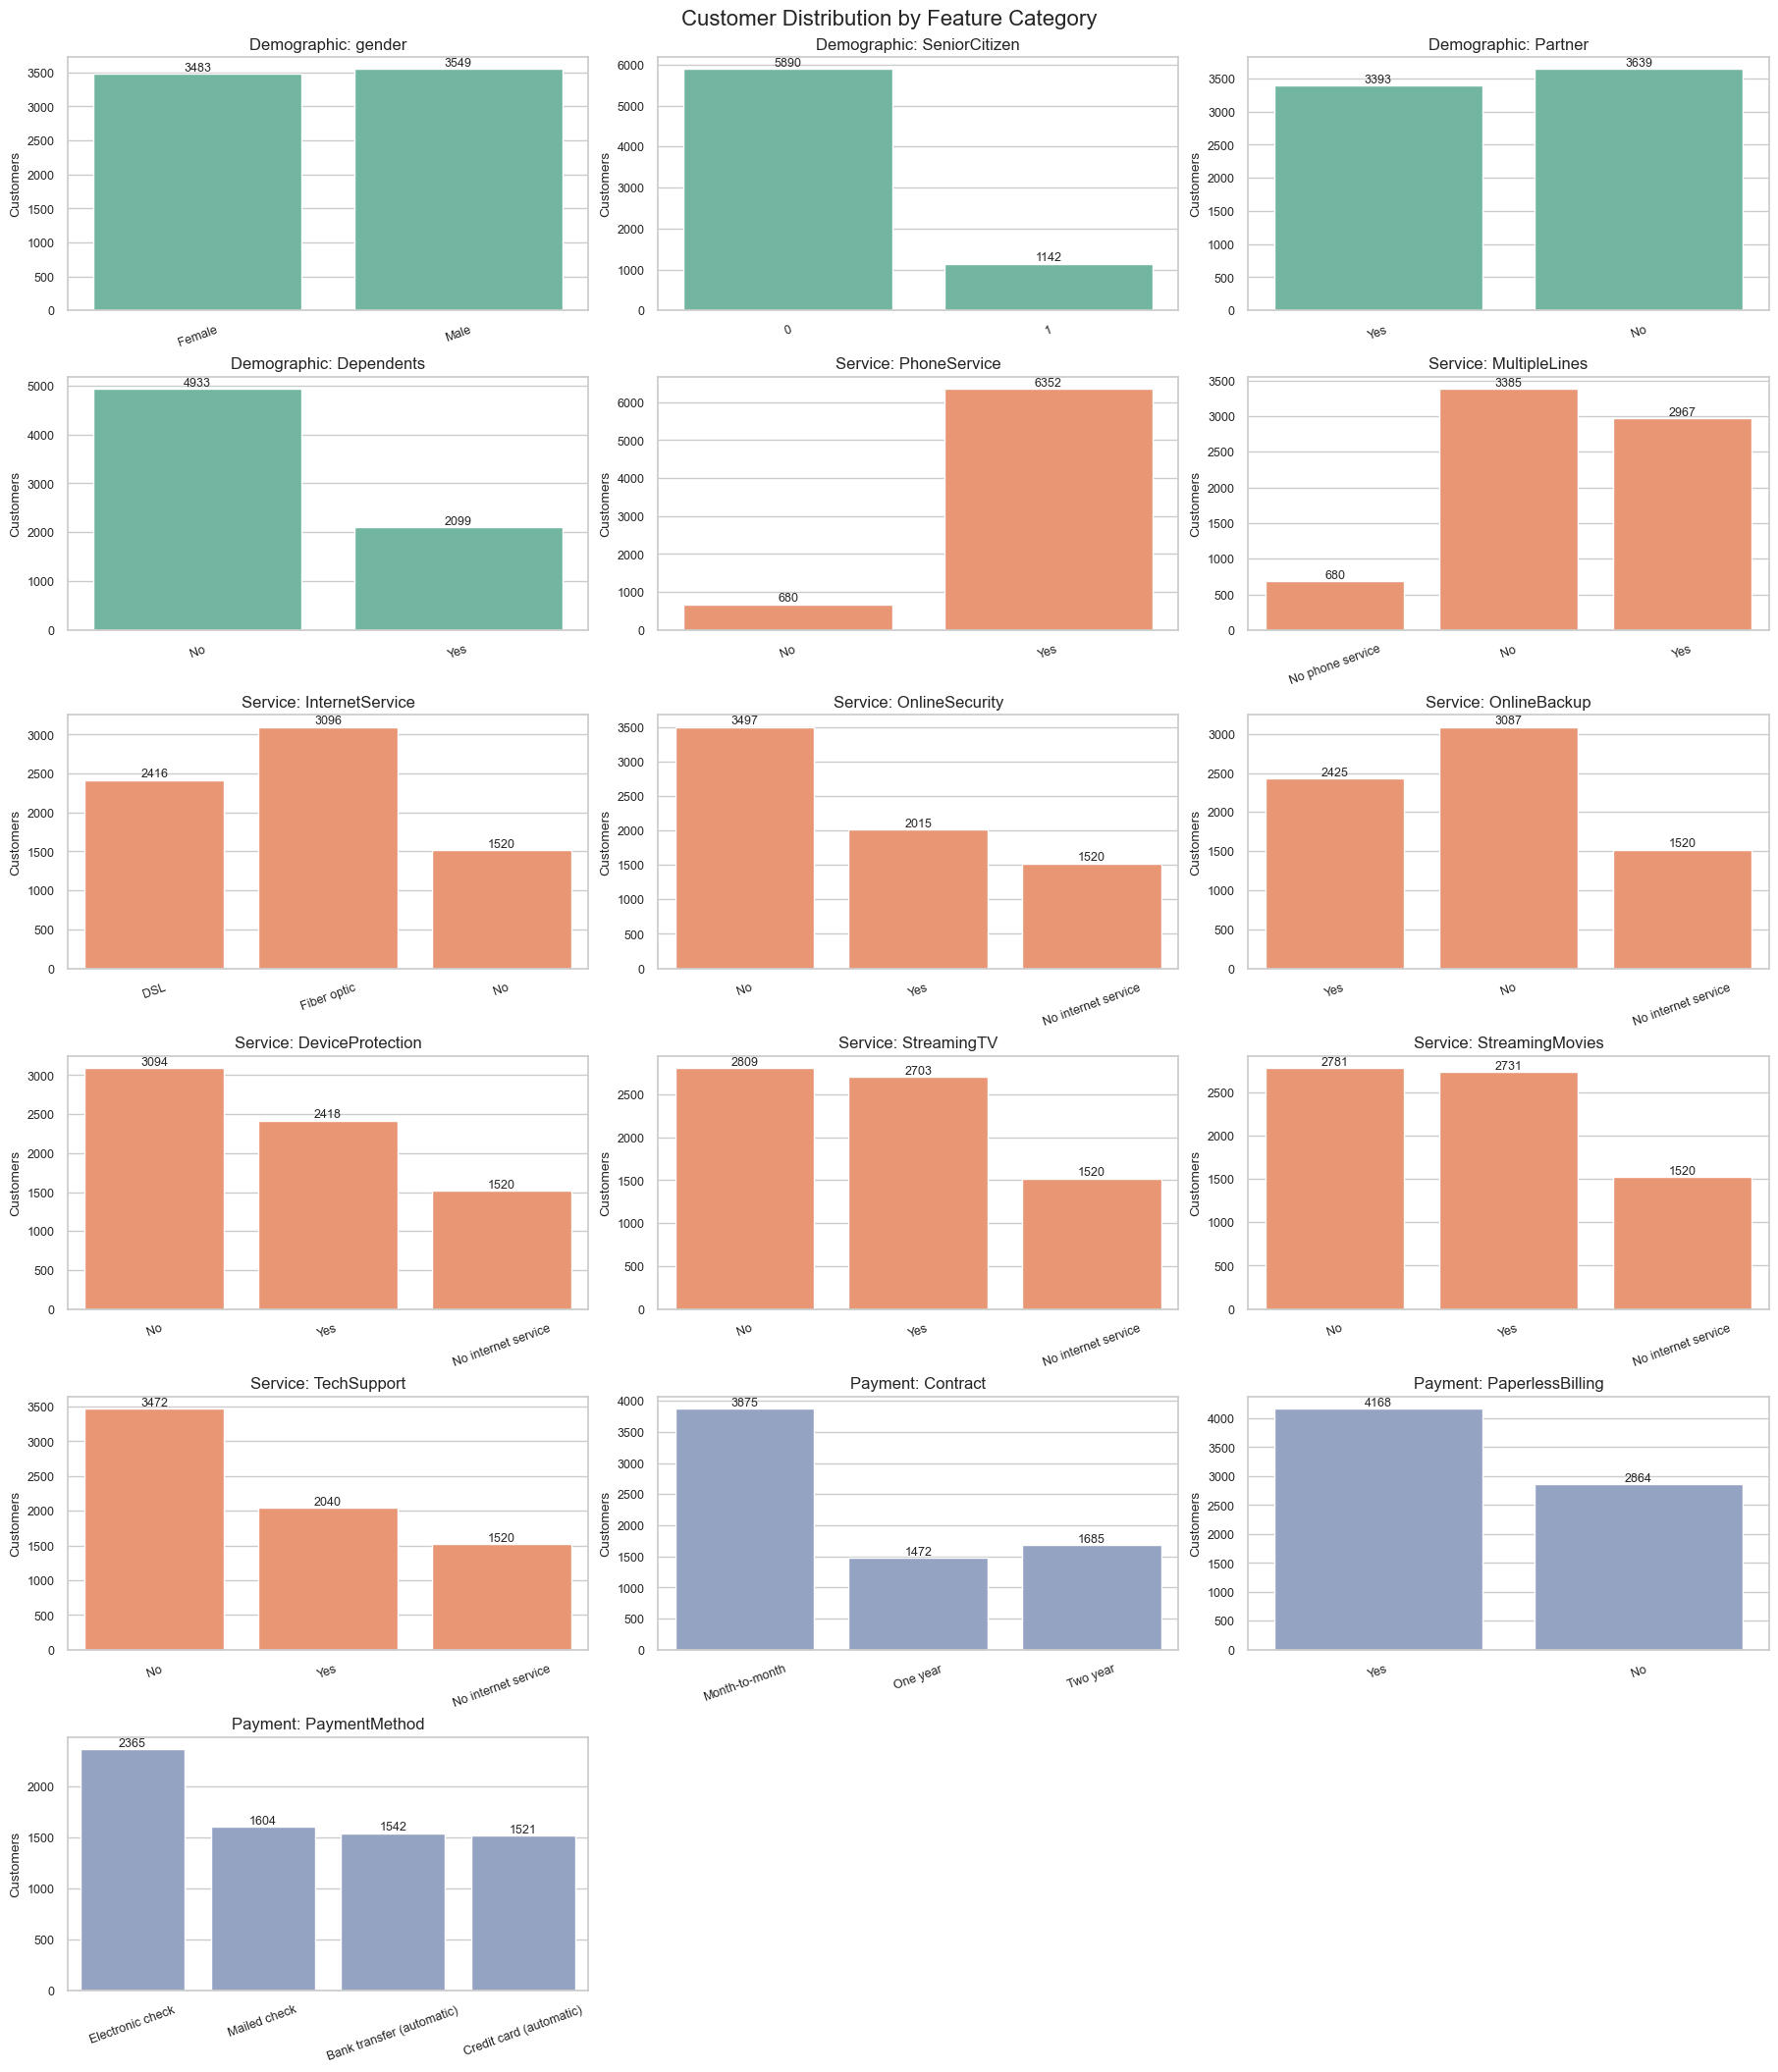

In [68]:
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, n_rows * 3.5), constrained_layout=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    category = feature_categories[i]
    sns.countplot(x=df[feature], ax=ax, color=category_colors[category])
    ax.bar_label(ax.containers[0], fontsize=9)
    ax.set_title(f"{feature_categories[i]}: {feature}", fontsize=12)
    ax.set_ylabel("Customers", fontsize=10)
    ax.set_xlabel("", fontsize=10)
    ax.tick_params(axis='x', labelrotation=20, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)

for j in range(len(features), len(axes)):
    axes[j].axis('off')

fig.suptitle("Customer Distribution by Feature Category", fontsize=16)
plt.show()


The count plots show how the values of each categorical feature are distributed. The demographic features are quite balanced. For example, the number of male and female customers is similar. Most customers are not senior citizens and do not have dependents.

For the service-related features, we see that many customers have phone service and internet. However, fewer people use services like tech support, device protection, or online security. These services might affect whether a customer stays or leaves. In the payment features, most customers have month-to-month contracts and use electronic checks. These choices may be related to a higher risk of churn because short contracts and certain payment types often mean lower customer loyalty.

These plots help us understand the data better and will guide the analysis of how these features relate to churn in the next step.


Now let's analyze the correlation of these categorical features with the target variable `Churn`. We will use a bar plot to visualize the correlation coefficients for each feature with respect to churn.

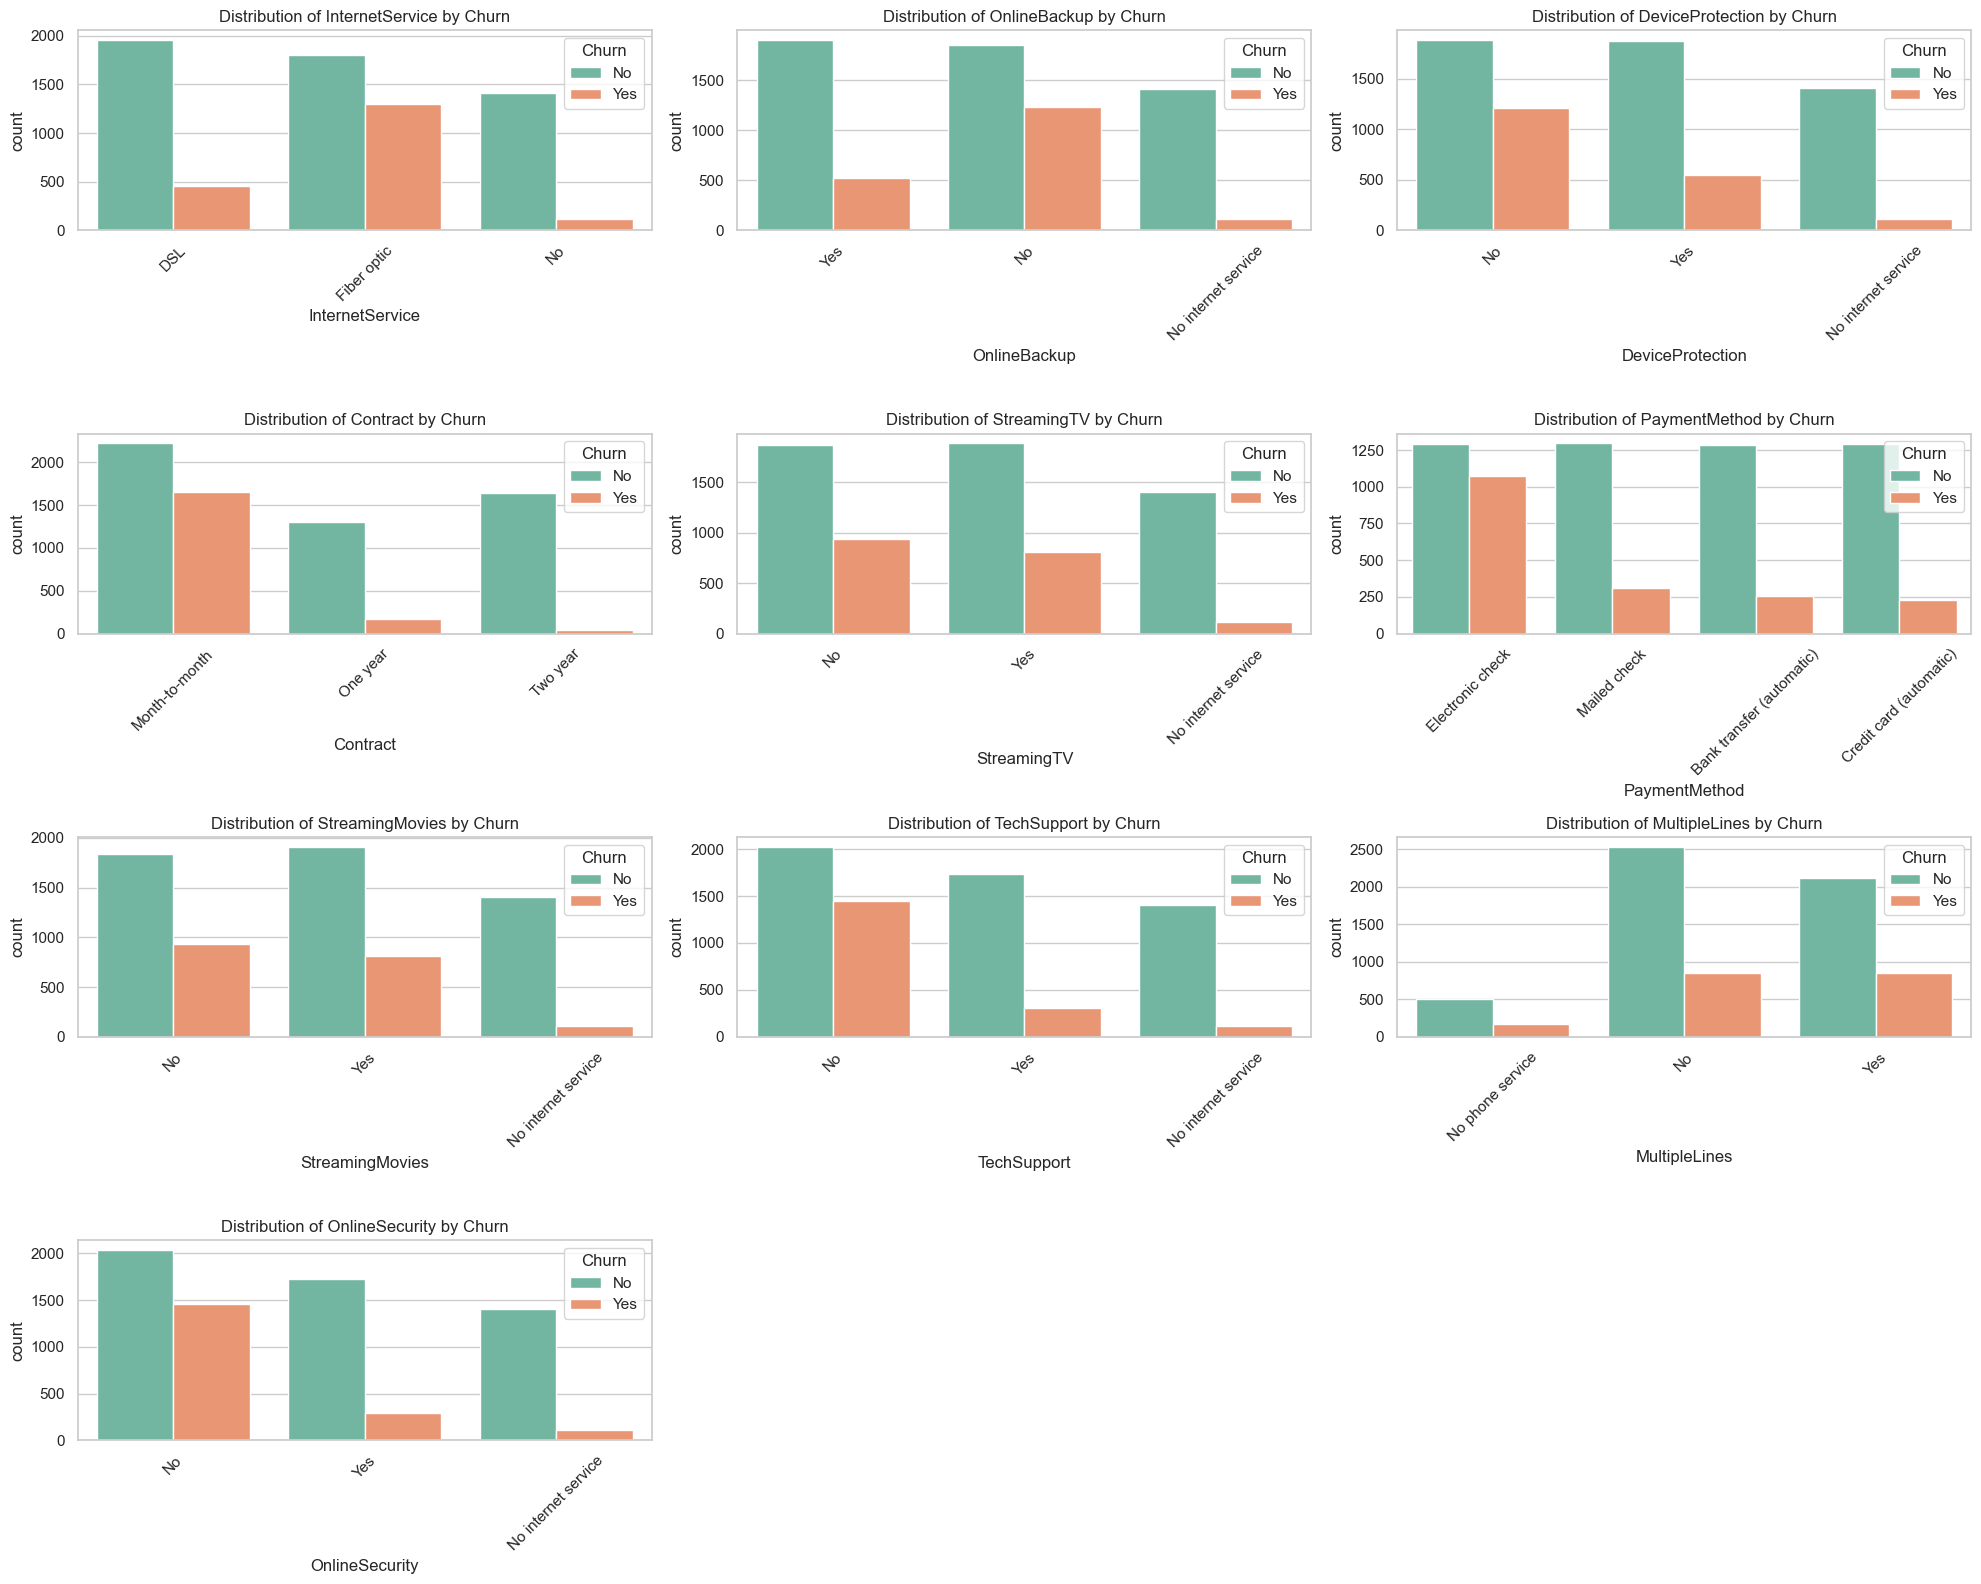

In [67]:
n_cols = 3
n_rows = (len(categorical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='Churn', data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Churn')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

From the grouped count plots, we can observe how different categories relate to the target variable `Churn`. Some features show a clear difference between customers who churned and those who did not.

For example, customers on **month-to-month contracts** show a much higher churn rate compared to those with one- or two-year contracts. This suggests that customers with flexible plans are more likely to leave. Similarly, people who use **electronic check** as their payment method also have higher churn, while customers who use credit cards or bank transfers tend to stay longer.

Service-related features like **OnlineSecurity**, **TechSupport**, and **DeviceProtection** also show strong patterns: churn is higher among those who do not use these services. This may indicate that customers who feel less supported or protected are more likely to leave. In contrast, for features like **StreamingTV** or **StreamingMovies**, the churn rates are more balanced across categories, meaning they might not be strong predictors of churn.

Overall, contract type, payment method, and use of support-related services appear to have the strongest correlation with churn.
